In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.linalg as SL
import scipy.sparse as SS
from scipy.sparse.linalg import eigs as ss_eigs
# too many imports clean this up
%matplotlib inline

## Define fns

We define the Hamiltonian of a $(2n+1)$-dim quantum mechanical system. Easiest to show an example first. For $n=2$, we have

$$
H = \begin{bmatrix}
E_0 - 2\epsilon & 0& V& 0& 0 \\
0& E_0 - \epsilon & V& 0& 0 \\
V& V & E_0 & V& V&  \\
0&0&V&E_0 + \epsilon&0\\
0& 0&V&0&E_0 + 2\epsilon\\
\end{bmatrix}
$$

More generally,
- We have states labeled by integers $-n \le j \le n$
  - The state "0" is special
- The Hamiltonian $H$ is given as follows
  - Diagonal elements
    - $H_{jj} = E_0 + \epsilon j$
  - Off-diagonal elements
    - $j\ne 0$ states are coupled to the special state with coupling $H_{j0} = V$
    - there is no coupling between the $j\ne 0$ states
    
     
In short, for $-n \le i, j \le n $, we have

$$
H_{ij} = \delta_{ij} (E_0 + \epsilon j) + (\delta_{i0} + \delta_{j0} - 2 \delta_{i0}\delta_{j0})V 
$$



Let us define a function that returns this Hamiltonian for given values of the constants $n$, $E_0$, $V$, $\epsilon$.

In [0]:
def h(n, e0=0, v=1, eps=1):
  H_0 = np.diag(np.ones(2*n + 1)*e0)
  H_eps = np.diag(np.arange(-n, n+1)*eps)
  H_v = np.block([
    [np.zeros([n,n]), np.ones([n,1]), np.zeros([n,n])],
    [np.ones([1,n]), 0, np.ones([1,n])],
    [np.zeros([n,n]), np.ones([n,1]), np.zeros([n,n])]
    ])
  return H_0 + H_eps + H_v

In [0]:
# should directly construct the sparse version
def hs(n, e0=0, v=1, eps=1):
    return SS.csr_matrix(h(n, e0, v, eps))

Example: $n=5$, $E_0=0$, $V=1$, $\epsilon=1$:

In [42]:
print(h(5))
print()
print(hs(5).toarray())

[[-5.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  4.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5.]]

[[-5.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  4.  0.]
 [ 0.  0.  

## Examples

In [0]:
n = 300

v   = 2
eps = 1.0
e0  = 0

nn=2*n+1
hn  = h(n=n, e0=e0, v=v, eps=eps)
hsn = hs(n=n, e0=e0, v=v, eps=eps)

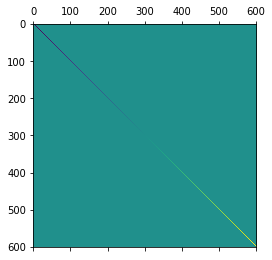

In [35]:
plt.matshow(hn)

In [0]:
eigval, eigvec = SL.eig(hn)
assert np.all(np.imag(eigval) == 0)
eigval = np.real(eigval)
order = np.argsort(-eigval)
eigvec = eigvec[:,order]
eigval = eigval[order]

k = 6
eigvals, eigvecs = ss_eigs(hsn, k=k)
assert np.all(np.imag(eigvals) == 0)
eigvals = np.real(eigvals)
orders = np.argsort(-eigvals)
eigvals = eigvals[orders]
eigvecs = eigvecs[:, orders]

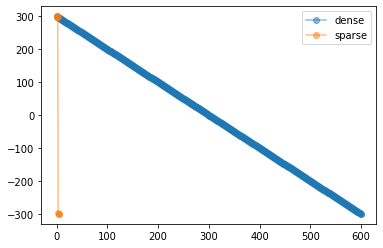

In [37]:
plt.plot(eigval, marker='o', alpha=.5, label='dense')
plt.plot(eigvals, marker='o', alpha=.5, label='sparse')
plt.legend()
plt.show()

Do sanity checks

In [38]:
np.abs(
    np.matmul(hn, eigvec) - np.matmul(eigvec, np.diag(eigval))
).max()

8.29913915367797e-12

In [0]:
# pad with zeros--maybe not needed to do the check
eigvecs_ext = np.block([eigvecs, np.zeros([nn, nn-k])])
eigvals_ext = np.concatenate([eigvals, np.zeros(nn-k)])

In [40]:
np.abs(
    np.matmul(hsn.toarray(), eigvecs_ext) - np.matmul(
        eigvecs_ext,
        np.diag(eigvals_ext)
    )
).max()

2.7853275241795927e-12

### Look at the decay

Can do with both direct exponentiation or using the eig decomposition of [1, 0, 0, 0]

In [0]:
# check that eigvecs are orthonormal
assert np.isclose(np.matmul(eigvec.T,eigvec), np.eye(nn)).all()

init = np.concatenate([np.array([1]), np.zeros(nn-1)])
init_comp = np.matmul(init, eigvec)

assert (init_comp == eigvec[0,:]).all()

In [0]:
# time const of exp decay
tau = 1/(2*np.pi*v**2/e)

In [0]:

tau

0.039788735772973836

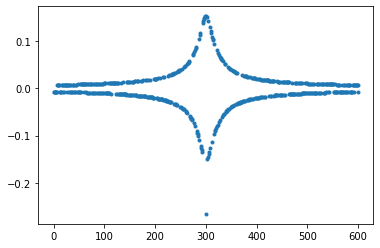

In [0]:
plt.plot(init_comp,'.')

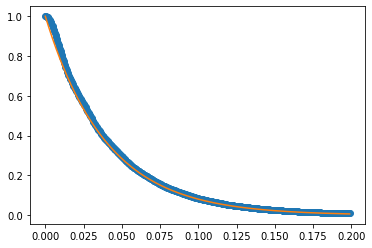

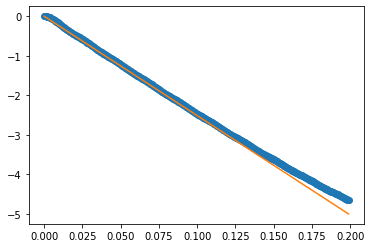

In [0]:
t_state_p = []
# can do this in a vectorized way
tgrid =np.linspace(0, 5*tau, 500)
for t in tgrid:
    t_comp = np.exp(1j*eigval*t) * init_comp
    t_state = np.matmul(eigvec, t_comp)
    t_state_p += [np.abs(t_state)**2]

assert np.isclose([p.sum() for p in t_state_p], 1).all()

decay = np.array([t_state_p[i][0] for
                  i in range(len(t_state_p))])
plt.plot(tgrid, decay, marker='o')
plt.plot(tgrid, np.exp(-tgrid/tau))
plt.show()
plt.plot(tgrid, np.log(decay), marker='o')
plt.plot(tgrid, -tgrid/tau)
plt.show()
